# Plots for Needle in Haystack Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc

/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda


#### Experiment Details

In [14]:
valA = "ident"
valC = "_ident_C"
state_dim = 5
ckpt_step = 141000
experiment = "250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = True

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "/needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading seg ext quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Errors location: {errs_loc}")

Loading quartiles from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/quartiles.npz
Loading seg ext quartiles from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/seg_ext_quartiles.npz
Errors location: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=141000.ckpt/needle_val_ident_state_dim_5_


#### load the err_lss_examples at path which is numpy array

In [15]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [16]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

shape of examples[MOP]: (200, 19, 2000, 251)
shape of examples[Zero]: (200, 19, 2000, 251)
shape of examples[Kalman_rem]: (200, 19, 2000, 251)
shape of examples[Analytical_Kalman]: (200, 19, 251)
shape of examples[Analytical_Simulation]: (200, 19, 2000, 251)
shape of examples[OLS_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_ir_3]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_3]: (200, 19, 2000, 251)
shape of seg_ext_examples[MOP]: (200, 1, 2000, 251)
shape of seg_ext_examples[Zero]: (200, 1, 2000, 251)
shape of seg_ext_examples[Kalman_rem]: (200, 1, 2000, 251)
shape of seg_ext_examples[Analytical_Kalman]: (200, 1, 251)
shape of seg_ext_examples[Analytical_Simulation]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_ir_1]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_analytical_ir_1]: (200, 1, 

#### Compute the Quartiles

In [17]:
def comp_quartiles(err_lss_examples, ratio=False, train_conv=False, kal_err=None):
    quartiles = {}
    if ratio:
        if not train_conv:
            kal_err = err_lss_examples["Kalman_rem"]

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            # print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            # print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [18]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
os.makedirs(os.path.dirname(quartiles_file), exist_ok=True)
np.savez(quartiles_file, **quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Analytical_Simulation]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_3]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 19, 251)


In [19]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
os.makedirs(os.path.dirname(seg_ext_quartiles_file), exist_ok=True)
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 1, 251)
shape of quartiles[MOP]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Zero]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Analytical_Simulation]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_3]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 1, 251)


## Plotting Code

### final trace

In [3]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

quartiles[mop] shape: (3, 19, 251), seg_ext_quartiles[mop] shape: (3, 1, 251)
haystack_len: 19


real_steps: [230, 231, 239], real_steps_ext: [228, 229, 237]
key_count: 0
needle: 0, step: 1, real_step: 230
y: 1.7025214032302114
needle: 0, step: 2, real_step: 231
y: 1.9053346265414755
needle: 0, step: 10, real_step: 239
y: 1.504156483207741
key_count: 1
needle: 0, step: 1, real_step: 230
y: 2.5683659998943824
needle: 0, step: 2, real_step: 231
y: 2.5726403005280605
needle: 0, step: 10, real_step: 239
y: 2.567371872052572
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 0
needle: 1, step: 1, real_step: 230
y: 1.726374191665749
needle: 1, step: 2, real_step: 231
y: 1.5935481080871483
needle: 1, step: 10, real_step: 239
y: 1.3990623182247557
key_count: 1
needle: 1, step: 1, real_step: 230
y: 2.5683659998943824
needle: 1, step: 2, real_step: 231
y: 2.5726403005280605
needle: 1, step: 10, real_step: 239
y: 2.567371872052572
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 0
needle: 

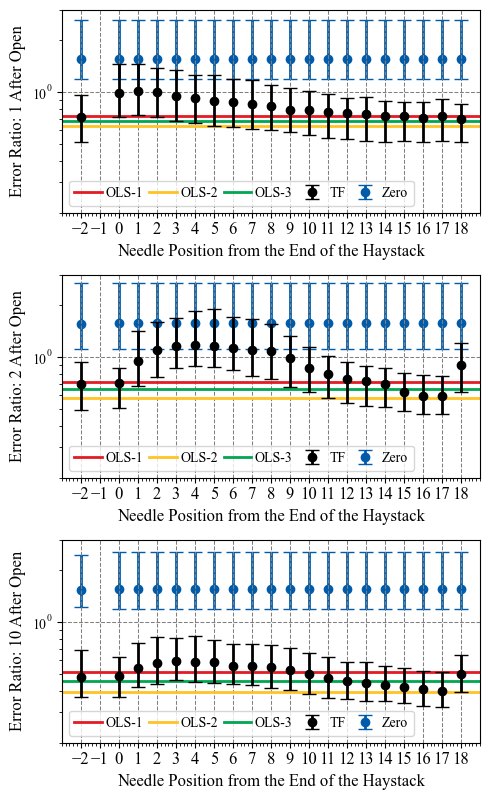

In [5]:
steps_in = [1,2,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(5, 2.7*len(steps_in))) #

#get a high contrast color map
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])
                if valA == "gaussA":
                   ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                    )
                else:
                    if key == "Zero":
                        color = colors[1]
                    elif step == 1:
                        color = colors[0]
                    elif step == 2:
                        color = colors[2]
                    elif step == 10:
                        color = colors[3]
                    ax.errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=((f"{key_label}" + (f": {step} After Open" if key == "MOP" else "")) if (needle == 0 and key == "MOP") or (needle == 0 and step == 1) else "_nolegend_"),
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=color,
                    linewidth=2
                    )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            if valA == "gaussA":
                ax[step_count].errorbar(
                    -2,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                    linewidth=2
                )
            else:
                if key == "Zero":
                    color = colors[1]
                elif step == 1:
                    color = colors[0]
                elif step == 2:
                    color = colors[2]
                elif step == 10:
                    color = colors[3]
                ax.errorbar(
                    -2 + step_count*0.02,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = color, 
                    linewidth=2
                )

            if valA != "gaussA":
                ax.legend(fontsize = 8, ncol=1, columnspacing=0.25)#, loc="upper left")
                ax.set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax.set_ylabel(("(" if valA== "gaussA" else "") + "Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=12)
                ax.set_xlim(-3, haystack_len)
                ax.grid(True)
                ax.minorticks_on()
                ax.grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax.set_xticks(np.arange(-2, haystack_len, 1))
                ax.set_yscale('log')
                # ax[step_count].set_ylim(0.3, 3)
                ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)

            step_count += 1
        key_count += 1

if valA == "gaussA":
    for key in quartiles.keys():
        if "OLS" in key and "analytical" not in key:
            print(f"key_count: {key_count}")
            print(f"quartiles[{key}].shape: {quartiles[key].shape}")
            step_count = 0
            for step in steps_in:
                y = quartiles[key][1, :, real_steps[step_count]]
                y -= 1
                ax[step_count].axhline(y[0], label=key[:3] + "-" + key[7:], color=colors[key_count], linewidth=2, linestyle='-')


                ax[step_count].legend(fontsize = 10, ncol=5, columnspacing=0.4, handletextpad=0.25)#, loc="upper left")
                ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax[step_count].set_ylabel("Error" + (" Ratio" if valA == "gaussA" else "") + f": {step} After Open", fontsize=12)
                ax[step_count].set_xlim(-3, haystack_len)
                ax[step_count].grid(True)
                ax[step_count].minorticks_on()
                ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
                ax[step_count].set_yscale('log')
                ax[step_count].set_ylim([2e-1, 3])
                ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
                step_count += 1
            key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



In [7]:
if valA == "gaussA":
    quartilez_npz = quartiles
    seg_ext_quartiles_npz = seg_ext_quartiles
    quartiles = {key: quartiles[key] for key in quartiles.keys()}
    seg_ext_quartiles = {key: seg_ext_quartiles_npz[key] for key in seg_ext_quartiles_npz.keys()}
    for key in quartiles.keys():
        seg_ext_quartiles[key] -= 1
        quartiles[key] -= 1

haystack_len: 19


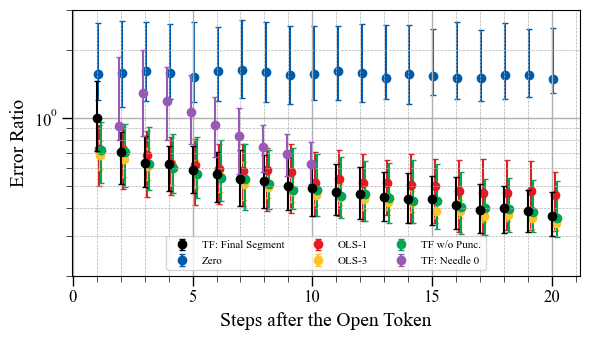

In [8]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3.5))
# fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(5, 5*haystack_len))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

col_count = 0
dither = 0.05

open_paren_ind = 229
fin_seg_len = 250-open_paren_ind -1
x_values = np.arange(1, fin_seg_len+1)

print(f"haystack_len: {haystack_len}")
ax_count = 0
needle = haystack_len - 1
for key in quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key and key != "OLS_ir_2":
        ax.errorbar(x_values + col_count*dither, quartiles[key][1, needle][open_paren_ind+1:-1], yerr=[quartiles[key][1, needle][open_paren_ind+1:-1] - quartiles[key][0, needle][open_paren_ind+1:-1], quartiles[key][2, needle][open_paren_ind+1:-1] - quartiles[key][1, needle][open_paren_ind+1:-1]], fmt='o', label="TF: Final Segment" if key == "MOP" else (key[:3] + "-" + key[7:] if "OLS" in key else f"{key}"), capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
        col_count += 1

needle = 0
# for key in seg_ext_quartiles.keys():
#     if "OLS_analytical" not in key:



y_values = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_lower = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][0, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_upper = seg_ext_quartiles["MOP"][2, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]

ax.errorbar(x_values + dither*col_count, y_values, yerr=[yerr_lower, yerr_upper], fmt='o', label=f"TF w/o Punc.", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1

needle = 0 #get the first needle
open_paren_ind = 1
key = "MOP"

fin_seg_len = 10

ax.errorbar(x_values[:10] + -dither, quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], yerr=[quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][0, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], quartiles[key][2, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len]], fmt='o', label="TF: Needle 0", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1
        
ax.legend(ncol=3 if valA == "gaussA" else 1, fontsize=8)
ax.grid(which="both")
# ax.set_xlim(left=230, right=seg_ext_quartiles[key].shape[-1] - 1)  # set the x axis limits haystack_len*12 + 2
# ax.set_ylim(bottom=0, top=5.5)  # set the y axis limits

# Optionally, customize major and minor ticks
ax.minorticks_on()

# Set minor vertical grid lines to be on intervals of 1
# Set major ticks on every interval of 50
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

# Set minor vertical grid lines to be on intervals of 1
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)

ax.tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
ax.tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5)
ax.set_ylabel(f"Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_xlabel("Steps after the Open Token", fontsize=14)
ax.set_yscale('log')
# ax.set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)
if valA == "gaussA":
    ax.set_ylim([2e-1, 3])

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# #add a caption to the bottom of the figure
# fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)
plt.tight_layout()

fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/last_seg_context_{valA}.pdf", transparent=True)

# Needle in a Haystack: Training Convergence

In [15]:
minval = 100
maxval = 15600
interval = 100
ckpt_steps = gen_ckpt_steps(minval, maxval, interval)
batch_size = 512
gpus=2

kal_ckpt = 126000
kal_err = None

if valA == "gaussA":
    rat = True
else:
    rat = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

haystack_len = 1

train_conv_fin_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_fin_quartiles_haystack_len_{haystack_len}.pkl"
train_conv_beg_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_beg_quartiles_haystack_len_{haystack_len}.pkl"
x_values_file = model_dir + experiment + f"/needles/train_conv/x_values_haystack_len_{haystack_len}.npy"



if os.path.exists(train_conv_fin_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_fin_quartiles_file}")
    with open(train_conv_fin_quartiles_file, "rb") as f:
        fin_quartiles_ckpt = pickle.load(f)

if os.path.exists(train_conv_beg_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_beg_quartiles_file}")
    with open(train_conv_beg_quartiles_file, "rb") as f:
        beg_quartiles_ckpt = pickle.load(f)

if os.path.exists(x_values_file):
    x_values = np.load(x_values_file)

ckpt_steps: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600]


loading errors for ckpt_step: 100
seg_starts_per_config: [[1, 13]]
batch_size: 512, gpus: 2, ckpt_step: 100, last_pred_ckpt: 0
x_value: 102400
loading errors for ckpt_step: 200
batch_size: 512, gpus: 2, ckpt_step: 200, last_pred_ckpt: 100
x_value: 204800
loading errors for ckpt_step: 300
batch_size: 512, gpus: 2, ckpt_step: 300, last_pred_ckpt: 200
x_value: 307200
loading errors for ckpt_step: 400


/home/sultand/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


batch_size: 512, gpus: 2, ckpt_step: 400, last_pred_ckpt: 300
x_value: 409600
loading errors for ckpt_step: 500
batch_size: 512, gpus: 2, ckpt_step: 500, last_pred_ckpt: 400
x_value: 512000
loading errors for ckpt_step: 600
batch_size: 512, gpus: 2, ckpt_step: 600, last_pred_ckpt: 500
x_value: 614400
loading errors for ckpt_step: 700
batch_size: 512, gpus: 2, ckpt_step: 700, last_pred_ckpt: 600
x_value: 716800
loading errors for ckpt_step: 800
batch_size: 512, gpus: 2, ckpt_step: 800, last_pred_ckpt: 700
x_value: 819200
loading errors for ckpt_step: 900
batch_size: 512, gpus: 2, ckpt_step: 900, last_pred_ckpt: 800
x_value: 921600
loading errors for ckpt_step: 1000
batch_size: 512, gpus: 2, ckpt_step: 1000, last_pred_ckpt: 900
x_value: 1024000
loading errors for ckpt_step: 1100
batch_size: 512, gpus: 2, ckpt_step: 1100, last_pred_ckpt: 1000
x_value: 1126400
path: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


batch_size: 512, gpus: 4, ckpt_step: 14600, last_pred_ckpt: 13600
x_value: 20070400
path: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=14700.ckpt/train_conv_needle_haystack_len_1_val_ident_state_dim_5_err_lss_examples for ckpt_step: 14700 does not exist.
path: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=14800.ckpt/train_conv_needle_haystack_len_1_val_ident_state_dim_5_err_lss_examples for ckpt_step: 14800 does not exist.
path: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=14900.ckpt/train_conv_needle_haystack_len_1_val_ident_state_dim_5_err_lss_examples for ckpt_step: 14900 does not exist.
path: ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

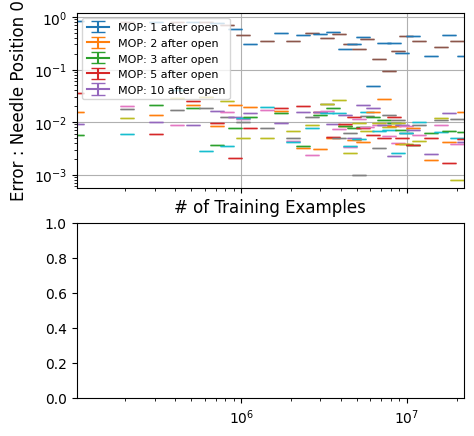

In [18]:
steps_in = [1,2,3,5,10]

fig, ax = plt.subplots(max(2,haystack_len), 1, sharex=True, figsize=(5, 5))


quartiles_ckpt = []
pred_ckpts = []
last_pred_ckpt = 0
x_values = []
ys = {}
y_errs = {}
fin_quartiles_ckpt = {}
beg_quartiles_ckpt = {}

if valA == "gaussA":
    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={kal_ckpt}.ckpt"
    # errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_" 
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_"

    with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            kal_ckpt_errs = pickle.load(f)

    kal_err = kal_ckpt_errs["Kalman_rem"]

for ckpt_step in ckpt_steps:

    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
    errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_"
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_" 

    if os.path.exists(errs_loc + "err_lss_examples.pkl"):
        print(f"loading errors for ckpt_step: {ckpt_step}")

        if len(pred_ckpts) > 0:
            last_pred_ckpt = pred_ckpts[-1]
            
            if valA == "ortho": #THIS IS FOR VANILLA ORTHO ONLY
                gpus = 2 #just for ortho case
            
            elif valA == "ident" and ckpt_step > 9600: #THIS IS FOR VANILLA IDENT ONLY
                gpus = 4

        else:
            last_pred_ckpt = 0
            if valA == "ortho":
                gpus = 3

        with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            err_lss_examples = pickle.load(f)

        # if os.path.exists(seg_ext_errs_loc + "err_lss_examples.pkl"):
        #     with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
        #         seg_ext_err_lss_examples = pickle.load(f)

        if len(pred_ckpts) == 0:
            #get seg_starts
            seg_starts_per_conf = get_seg_starts_per_config(experiment, valA, valC, state_dim, ckpt_step, print_seg_starts=True, nope=nope, needle=True, haystack_len=haystack_len, train_conv=True)

        quartiles = comp_quartiles(err_lss_examples, ratio=rat, train_conv=True, kal_err=kal_err)

        del err_lss_examples
        #clear cuda cache
        torch.cuda.empty_cache()
        gc.collect()

        print(f"batch_size: {batch_size}, gpus: {gpus}, ckpt_step: {ckpt_step}, last_pred_ckpt: {last_pred_ckpt}")
        if len(x_values) > 0:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt) + x_values[-1]
        else:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt)

        print(f"x_value: {x_value}")
        x_values.append(x_value)
        for needle in range(1):
            fin_seg_start = seg_starts_per_conf[needle][-1]
            beg_seg_start = seg_starts_per_conf[needle][0]
            for step in steps_in:
                for key in ["MOP"]:
                    if "OLS_analytical" not in key and key not in  ["Zero", "Analytical_Simulation", "Kalman_rem", "Kalman", "Analytical_Kalman"]:
                        key_lab = "TF" if key == "MOP" else key
                        
                        y = quartiles[key][1, needle, fin_seg_start + step]
                        
                        y_err = [
                            [quartiles[key][1, needle, fin_seg_start + step] - quartiles[key][0, needle, fin_seg_start + step]],
                            [quartiles[key][2, needle, fin_seg_start + step] - quartiles[key][1, needle, fin_seg_start + step]]
                        ]

                        if needle == 0:
                            if len(pred_ckpts) == 0:
                                if step == 1:
                                    ys[key] = {}
                                    y_errs[key] = {}
                                    fin_quartiles_ckpt[key] = {}
                                    beg_quartiles_ckpt[key] = {}

                                    # for ir in range(1,4):
                                    #     ys[f"OLS_ir_{ir}"] = {}
                                    #     y_errs[f"OLS_ir_{ir}"] = {}
                                    #     fin_quartiles_ckpt[f"OLS_ir_{ir}"] = {}
                                    #     beg_quartiles_ckpt[f"OLS_ir_{ir}"] = {}


                                # print("step: ", step)
                                # print(f"key: {key}, step: {step}")
                                ys[key][step] = [y]
                                y_errs[key][step] = [y_err]
                                fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                                beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                            # elif ckpt_step == kal_ckpt and "OLS" in key:
                            #     ys[key][step] = [y]
                            #     y_errs[key][step] = [y_err]
                            #     fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                            #     beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                                # print(f"ys: {ys}")
                            else:
                                # print(f"ys: {ys}")
                                # print("step after minval: ", step)
                                # print(f"ys: {ys}")
                                # print(f"key: {key}, step: {step}")
                                ys[key][step].append(y)
                                y_errs[key][step].append(y_err)
                                fin_quartiles_ckpt[key][step].append(quartiles[key][:, needle, fin_seg_start + step])
                                beg_quartiles_ckpt[key][step].append(quartiles[key][:, needle, beg_seg_start + step])

                        ax[needle].errorbar(x_value, y, y_err, label=f"{key}: {step} after open" if ckpt_step == minval else "_nolegend_", capsize=5, markersize=5)

            
            ax[needle].set_xlabel("# of Training Examples", fontsize=12)
            ax[needle].set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else "") + f": Needle Position {needle}", fontsize=12)
            ax[needle].set_yscale('log')
            ax[needle].set_xscale('log')
            ax[needle].grid(True)
            ax[needle].legend(fontsize=8)
            ax[needle].set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)

        pred_ckpts.append(ckpt_step)
    else:
        print(f"path: {errs_loc + "err_lss_examples"} for ckpt_step: {ckpt_step} does not exist.")
   
plt.show()


os.makedirs(os.path.dirname(train_conv_fin_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_fin_quartiles_file, "wb") as f:
    pickle.dump(fin_quartiles_ckpt, f)

os.makedirs(os.path.dirname(train_conv_beg_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_beg_quartiles_file, "wb") as f:
    pickle.dump(beg_quartiles_ckpt, f)

os.makedirs(os.path.dirname(x_values_file), exist_ok=True)
np.save(x_values_file, x_values)


        # seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/GPT2/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/figures/multi_sys_trace/ident_train_conv_haystack_len_1.pdf'

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

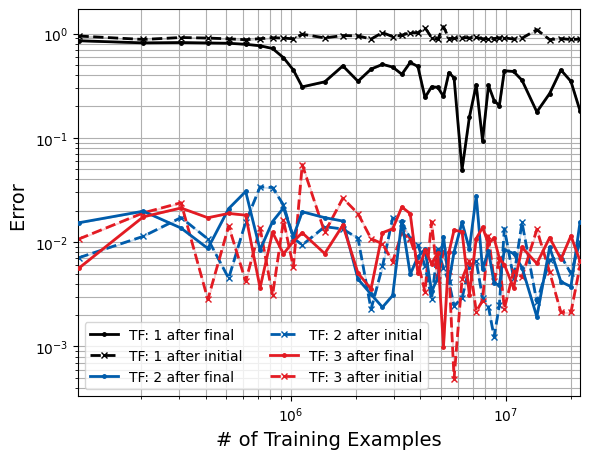

In [19]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651']

if valA == "ortho":
    steps = [1,2,3,5,10]
else:
    steps = [1,2,3]
for key in fin_quartiles_ckpt.keys():
    if key == "MOP":
        col_count = 0
        for step in steps:

            key_lab = "TF" if key == "MOP" else key
            qs = np.array(fin_quartiles_ckpt[key][step])
            qs = np.transpose(qs)

            if valA == "gaussA":
                qs -= 1

            #if key contains OLS then repeat the values in qs to be the length of x_values
            if "OLS" in key:
                print(f"key: {key} qs shape: {qs.shape}")
                qs = np.repeat(qs, len(x_values), axis=0)
                print(f"qs shape after repeat: {qs.shape}")
            ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final", markersize=5, marker=".", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
            if not valA == "gaussA":
                ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

            beg_qs = np.array(beg_quartiles_ckpt[key][step])
            beg_qs = np.transpose(beg_qs)
            #set the color to the same as the fin quartiles
            color = ax.get_lines()[-1].get_color()
            ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial", markersize=5, marker="x", color=color, linestyle="--", linewidth=2)

            if not valA == "gaussA":
                ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

            col_count += 1


ax.set_xlabel("# of Training Examples", fontsize=14)
ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend(fontsize=10, ncol=2 if valA =="ident" else 1, loc="lower left")
ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
# ax.set_ylim([5e-2, 3e0])
# ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")
plt.tight_layout()

fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/{valA}_train_conv_haystack_len_{haystack_len}.pdf", transparent=True, format="pdf")

plt.show()

In [14]:
print(qs)

[[0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887]
 [0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0

## haystack length plot

In [2]:
from haystack_plots import load_quartiles_ckpt_files
from get_last_checkpoint import split_path
import re

In [ ]:
def extract_trace_string(file_path):
    match = re.search(r'trace_(.*?)_state', file_path)
    if match:
        return match.group(1)
    else:
        return None

def haystack_len_plot(experiment_dict, colors):
    exp_count = 0
    for experiment_path in experiment_dict.keys():
        valA = extract_trace_string(experiment_path)
        model_size = experiment_dict[experiment_path]
        nope = "NoPE" in experiment_path

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))

        haystack_lens = np.arange(1,20)

        # model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

        dither = 0.05

        # experiment = "250125_104123.f75c04_multi_sys_trace_ortho_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000"

        model_dir, experiment = split_path(experiment_path)

        for haystack_len in haystack_lens:
            print("haystack_len: ", haystack_len)
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(haystack_len, model_dir, experiment)
            
            if fin_quartiles_ckpt is not None:
                steps = fin_quartiles_ckpt["MOP"].keys() #get the steps in from open token
            else:
                print(f"fin_quartiles_ckpt is None for haystack_len: {haystack_len}\n\n")
                continue

            step_count = 0
            for step in steps:
                print(f"step: {step}")
                qs = np.array(fin_quartiles_ckpt["MOP"][step]).T
                print(f"qs shape: {qs.shape}")

                if valA == "gaussA":
                    qs -= 1

                    # ax.scatter(haystack_len + dither*step_count*(-1**step_count), qs[1,last_ind], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", s=100, marker=".", color=colors[step_count])

                last_ind = len(qs[1]) - 1
                # print(f"\nx_value at last index: {x_values[last_ind]} for haystack_len: {haystack_len} and step: {step}\n")
                    
                ax.errorbar(haystack_len + dither*step_count*(-1**step_count), qs[1,last_ind], yerr=[[qs[1,last_ind] - qs[0,last_ind]], [qs[2,last_ind] - qs[1,last_ind]]], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", markersize=8, marker=".", color=colors[step_count], capsize=5, linewidth=2)
                    
                step_count += 1

        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

        # Set minor vertical grid lines to be on intervals of 1
        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)


        ax.set_xlabel("Haystack Length", fontsize=14)
        ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
        ax.set_yscale('log')
        ax.grid(True, which="both")
        ax.legend(fontsize=10)
        ax.set_xlim(0, 20)
        # ax.set_title(("NoPE " if nope else "") + ("Orthogonal " if valA == "ortho" else ("Gaussian " if valA == "gaussA" else "Identity ")) + f"Error vs Haystack Length: {model_size} Model")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M")


        os.makedirs(experiment_path + f"/figures/multi_sys_trace/", exist_ok=True)
        fig.savefig(experiment_path + f"/figures/multi_sys_trace/{valA}_haystack_len_plot_{timestamp}.pdf", transparent=True, format="pdf")
        exp_count += 1
    return None


def phase_tr_vs_model_size(experiment_dict, haystack_len, cutoffs = [1.5, 0.5, 0.5]):
    fig_gauss, ax_gauss = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
    fig_ortho, ax_ortho = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
    fig_ident, ax_ident = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

    for exper in experiment_dict.keys():
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(haystack_len, model_dir, experiment)

        valA = extract_trace_string(exper)
        model_size = experiment_dict[exper]
        nope = "NoPE" in exper

        if nope:
            continue
        else:
            if model_size == "tiny":
                num_params = 4
            elif model_size == "small":
                num_params = 5.7
            elif model_size == "medium":
                num_params = 9.1
            elif model_size == "big":
                num_params = 20.7

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}, num_params: {num_params}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for haystack_len: {haystack_len}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                ax = ax_gauss
                fig = fig_gauss
                cutoff_val = cutoffs[0]
            elif valA == "ortho":
                ax = ax_ortho
                fig = fig_ortho
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                ax = ax_ident
                fig = fig_ident
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                left_edge_x = -np.inf

            block_width = (np.log(num_params)/np.log(4))

            ax.fill_between([num_params - 0.5*block_width, num_params + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color="black")


    xlab = "Model Size (Million Parameters)"
    ylab = f"Training Examples to Reach Error of {cutoff_val}" +  (" Ratio" if valA == "gaussA" else "")
    plt_title = f"Phase Transition vs Model Size for Haystack Length {haystack_len}"
    # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
    ax_gauss.set_xlabel(xlab, fontsize=14)
    ax_gauss.set_ylabel(ylab, fontsize=14)
    ax_gauss.set_yscale('log')
    ax_gauss.set_xscale('log')
    ax_gauss.grid(True, which="both")
    ax_gauss.set_xlim([3, 30])

    # ax_ortho.set_title(plt_title + " Orthogonal", fontsize=16)
    ax_ortho.set_xlabel(xlab, fontsize=14)
    ax_ortho.set_ylabel(ylab, fontsize=14)
    ax_ortho.set_yscale('log')
    ax_ortho.set_xscale('log')
    ax_ortho.grid(True, which="both")
    ax_ortho.set_xlim([3, 30])

    # ax_ident.set_title(plt_title + " Identity", fontsize=16)
    ax_ident.set_xlabel(xlab, fontsize=14)
    ax_ident.set_ylabel(ylab, fontsize=14)
    ax_ident.set_yscale('log')
    ax_ident.set_xscale('log')
    ax_ident.grid(True, which="both")
    ax_ident.set_xlim([3, 30])


    fig_gauss.tight_layout()
    fig_ortho.tight_layout()
    fig_ident.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/model_size/", exist_ok=True)
    fig_gauss.savefig(f"../outputs/phase_transition/model_size/gauss_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ortho.savefig(f"../outputs/phase_transition/model_size/ortho_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ident.savefig(f"../outputs/phase_transition/model_size/ident_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    return None


def phase_tr_vs_haystack_len(experiment_dict, cutoffs = [1.5, 0.5, 0.5]):
    haystack_lens = np.arange(1,20)

    for exper in experiment_dict.keys():

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
        model_dir, experiment = split_path(exper)
        for haystack_len in haystack_lens:
            print(f"model_dir: {model_dir}, experiment: {experiment}")
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(haystack_len, model_dir, experiment)

            valA = extract_trace_string(exper)
            model_size = experiment_dict[exper]
            nope = "NoPE" in exper

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for model_size: {model_size}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                cutoff_val = cutoffs[0]
            elif valA == "ortho":
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                left_edge_x = -np.inf

            block_width = 0.5

            ax.fill_between([haystack_len - 0.5*block_width, haystack_len + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color="black")


        xlab = "Haystack Length"
        ylab = f"Training Examples to Reach Error of {cutoff_val} " +  (" Ratio" if valA == "gaussA" else "")
        plt_title = f"Phase Transition vs Haystack Length"
        # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
        ax.set_xlabel(xlab, fontsize=14)
        ax.set_ylabel(ylab, fontsize=14)
        ax.set_yscale('log')
        ax.set_xscale('linear')
        ax.grid(True, which="both")
        ax.set_xlim([0, 20])
        #make ticks on the x-axis integers and grid lines on the x-axis integers
        ax.set_xticks(range(0, 21, 1))




        fig.tight_layout()

        timestamp = datetime.now().strftime("%Y%m%d_%H%M")

        os.makedirs("../outputs/phase_transition/haystack_len/", exist_ok=True)
        fig.savefig(f"../outputs/phase_transition/haystack_len/" + ("NoPE_" if nope else "") + f"{valA}_{model_size}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")

    return None

In [18]:
ls = np.array([[1e-1,2e-1, 6e-1],[1e-1,1e-2, 1e-1],[1e-1,2e-1, 4e-1]])@np.array([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]])
print("shape of ls: ", ls.shape)
print(ls)
print("where shape: ", np.where(ls[1] > 0.5))
first_ind = np.where(ls[1] > 0.5)[0][0]
last_ind = np.where(ls[1] < 0.5)[0][-1]
print("last_ind: ", last_ind)
print("first_ind: ", first_ind)

shape of ls:  (3, 10)
[[0.9  1.8  2.7  3.6  4.5  5.4  6.3  7.2  8.1  9.  ]
 [0.21 0.42 0.63 0.84 1.05 1.26 1.47 1.68 1.89 2.1 ]
 [0.7  1.4  2.1  2.8  3.5  4.2  4.9  5.6  6.3  7.  ]]
where shape:  (array([2, 3, 4, 5, 6, 7, 8, 9]),)
last_ind:  1
first_ind:  2


In [7]:
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']
experiment_paths = ["../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250125_103302.919337_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_3.169786384922228e-05_num_train_sys_40000", "../outputs/GPT2/250125_104123.f75c04_multi_sys_trace_ortho_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000", "../outputs/GPT2/250125_110549.80eba5_multi_sys_trace_ident_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000", "../outputs/GPT2/250125_202437.caf35b_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.3207437987531975e-05_num_train_sys_40000", "../outputs/GPT2/250125_204545.a2cee4_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.3207437987531975e-05_num_train_sys_40000", "../outputs/GPT2/250125_210849.09203d_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.3207437987531975e-05_num_train_sys_40000", "../outputs/GPT2/250128_022150.04b6bf_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_6.339572769844456e-05_num_train_sys_40000", "../outputs/GPT2/250128_022310.fc649a_multi_sys_trace_ident_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000", "../outputs/GPT2/250128_022331.067361_multi_sys_trace_ortho_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000"]

print(len(experiment_paths))

model_sizes = ["medium", "medium", "medium", "medium", "medium", "medium", "small", "small", "small", "big", "big", "big", "tiny", "tiny", "tiny"]

print(len(model_sizes))

experiment_dict = dict(zip(experiment_paths, model_sizes))

valA = extract_trace_string(experiment_paths[2])
print(f"valA: {valA}")

print(f"is NoPE in experiment_paths[0]: {'NoPE' in experiment_paths[3]}")


15
15
valA: ident
is NoPE in experiment_paths[0]: True


model_dir: ../outputs/GPT2/, experiment: 250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_19.pkl
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_19.pkl
Loading x_values from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_19.npy


experiment: 250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000, model_size: medium, num_params: 9.1
shape of qs[1] (34,)
larger_than_cutoff: [ 0  1  2  3 

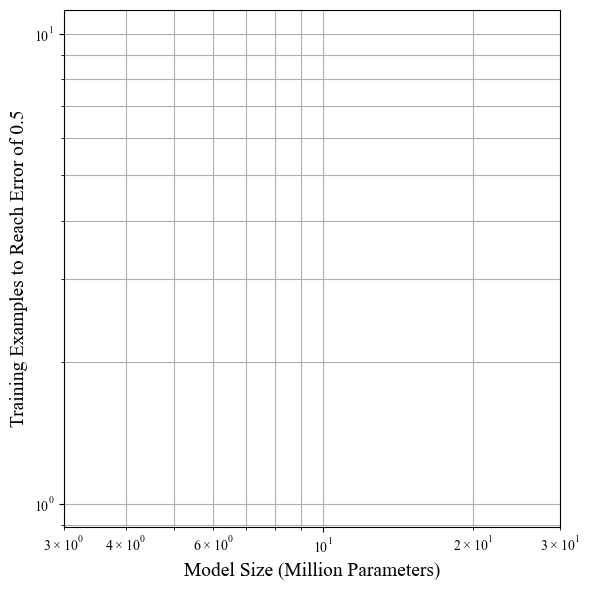

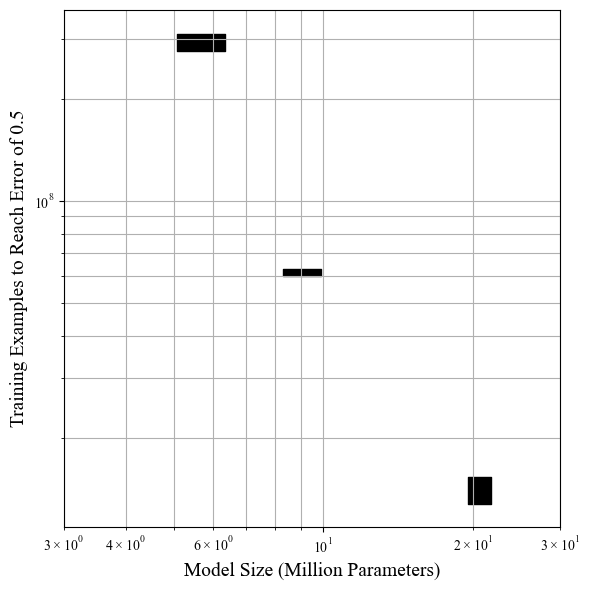

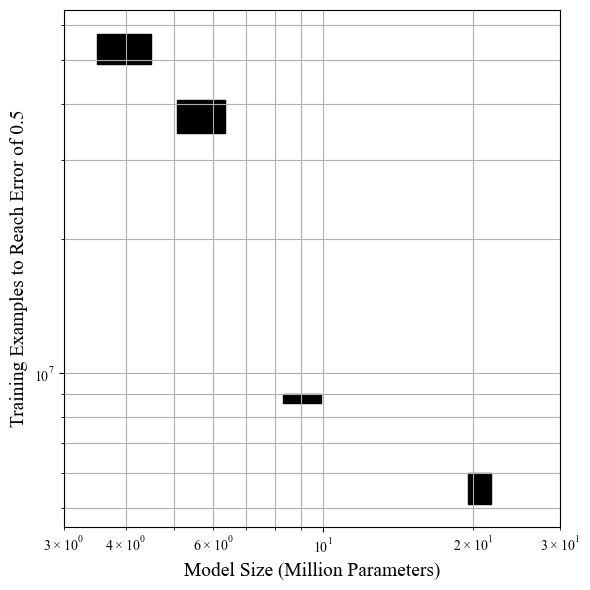

In [11]:
haystack_lens = [19] #np.arange(1,20)
for haystack_len in haystack_lens:
    phase_tr_vs_model_size(experiment_dict, haystack_len)

model_dir: ../outputs/GPT2/, experiment: 250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading x_values from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy


experiment: 250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000, model_size: medium
shape of qs[1] (34,)
larger_than_cutoff: [ 0  1  2  3  4  5  6  7  8  9 10

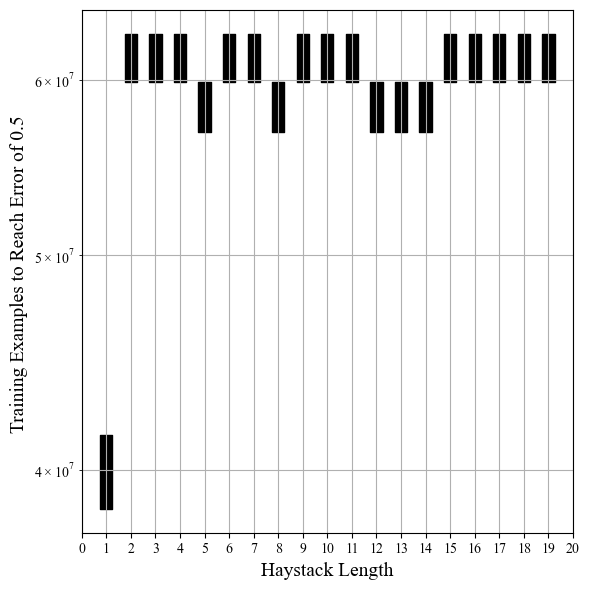

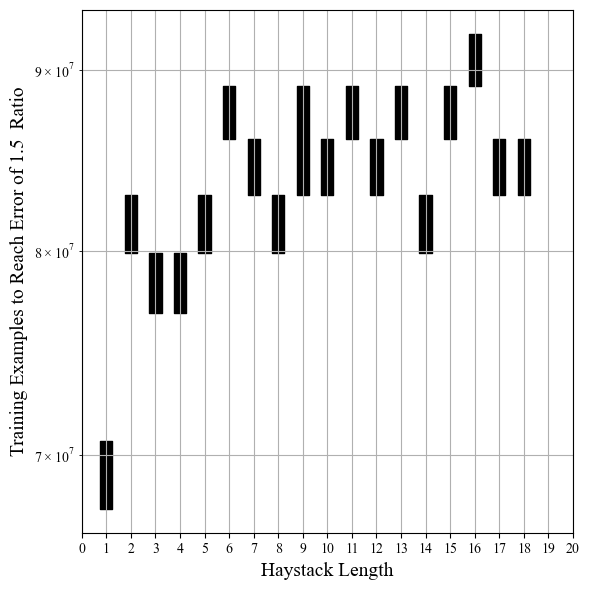

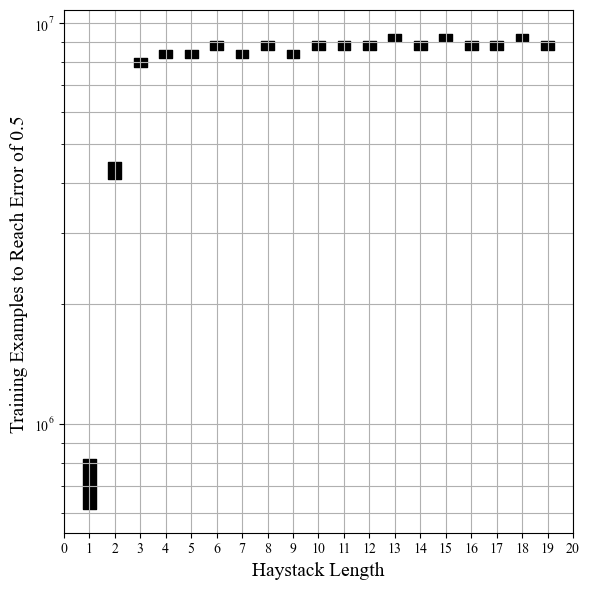

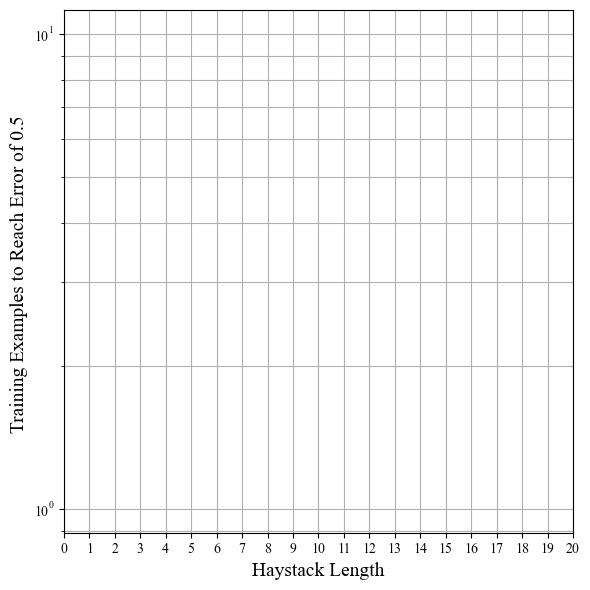

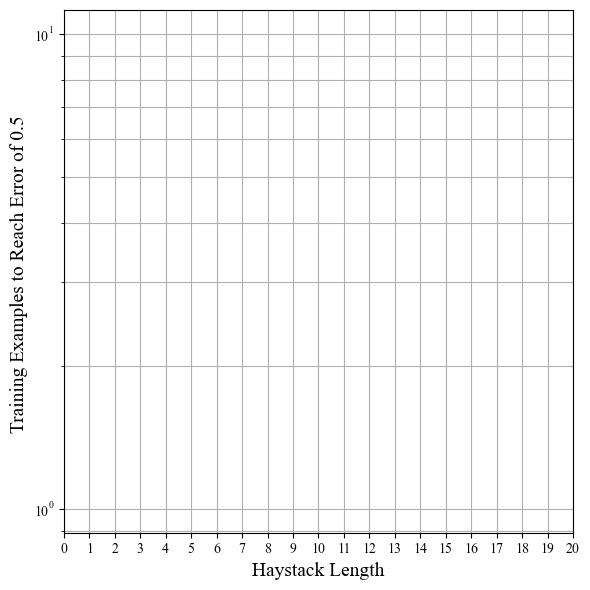

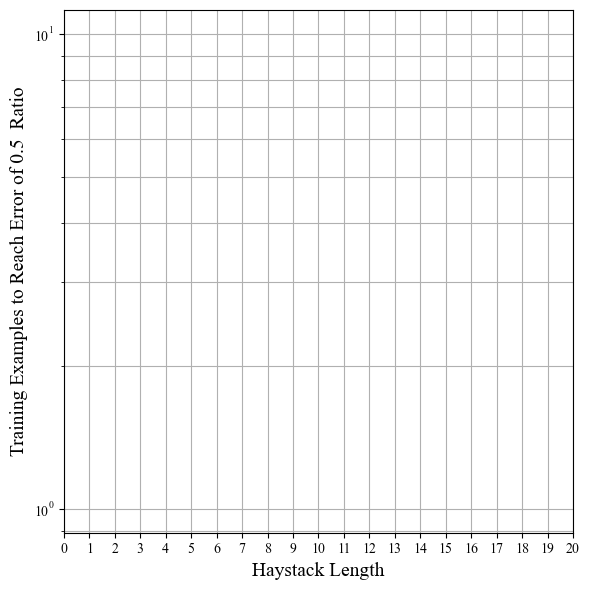

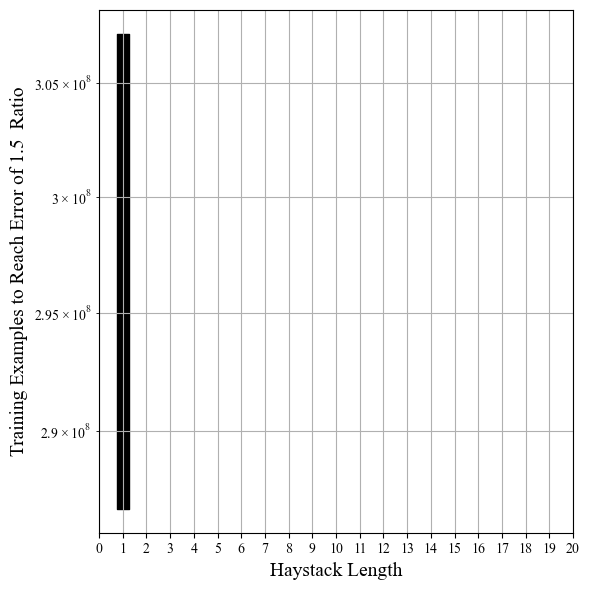

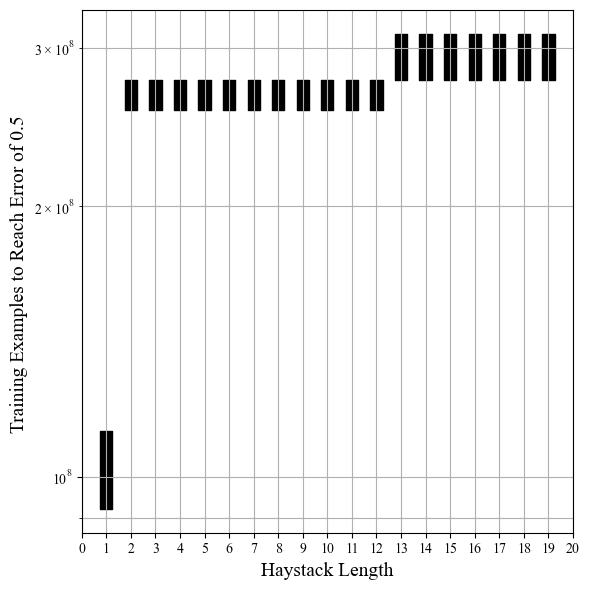

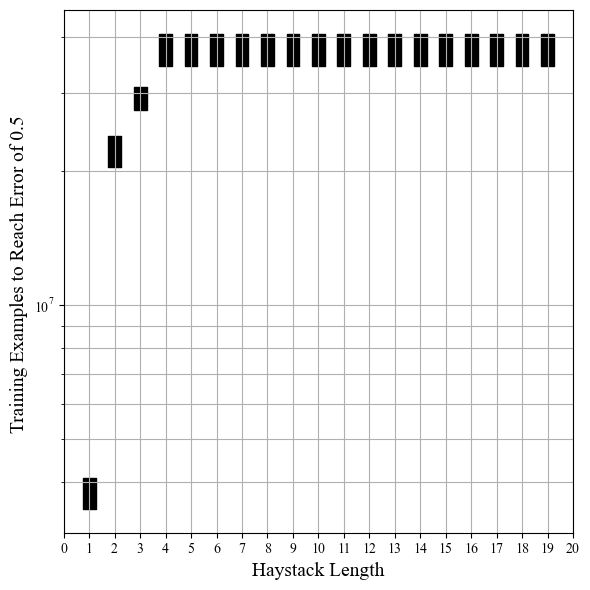

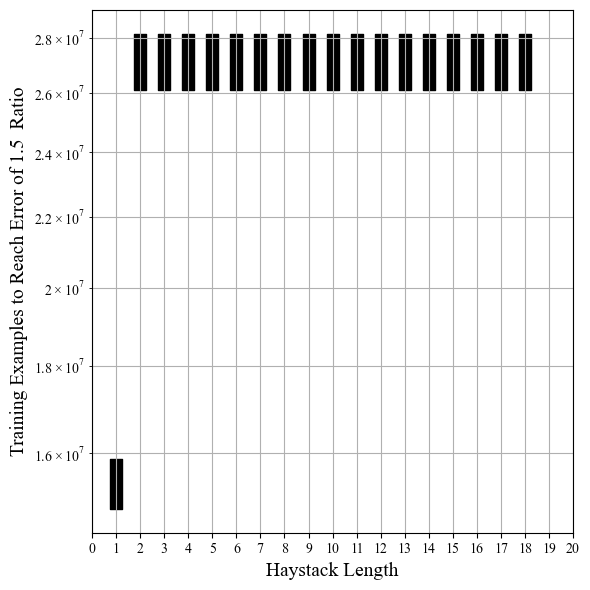

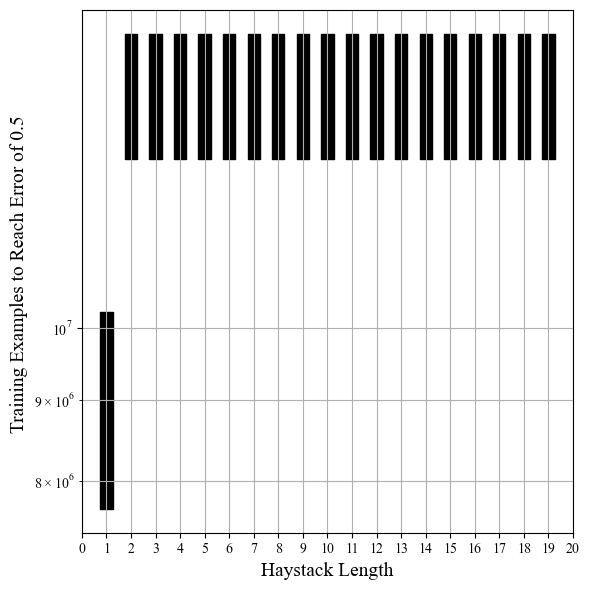

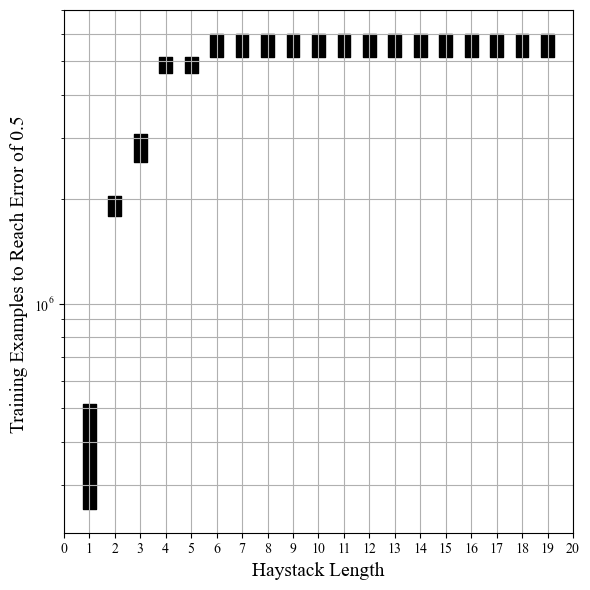

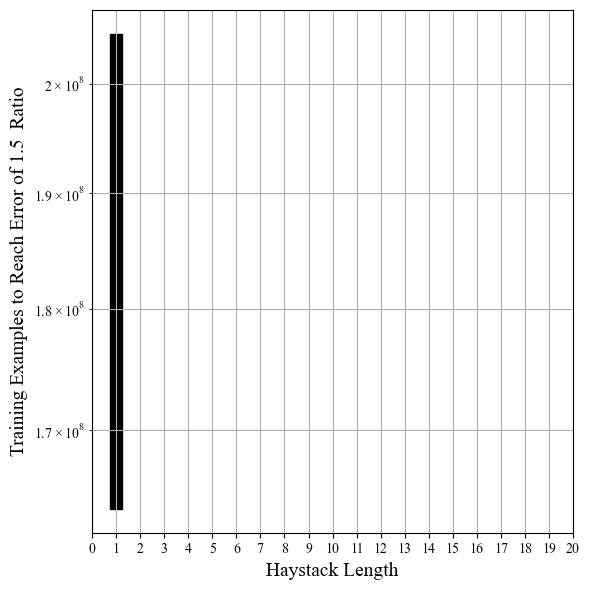

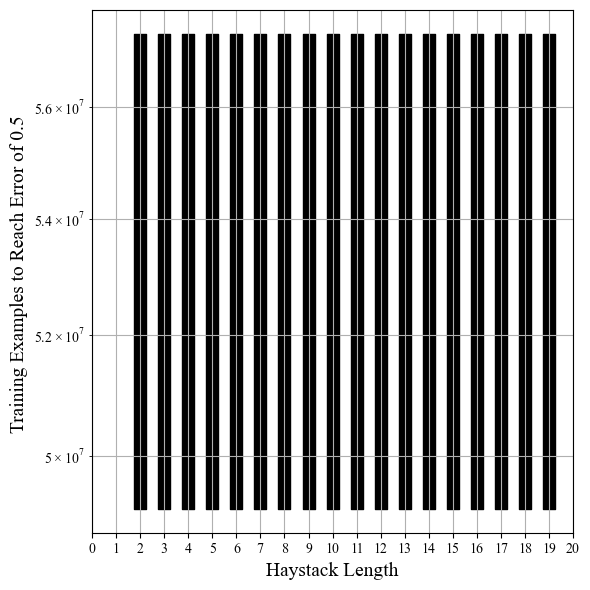

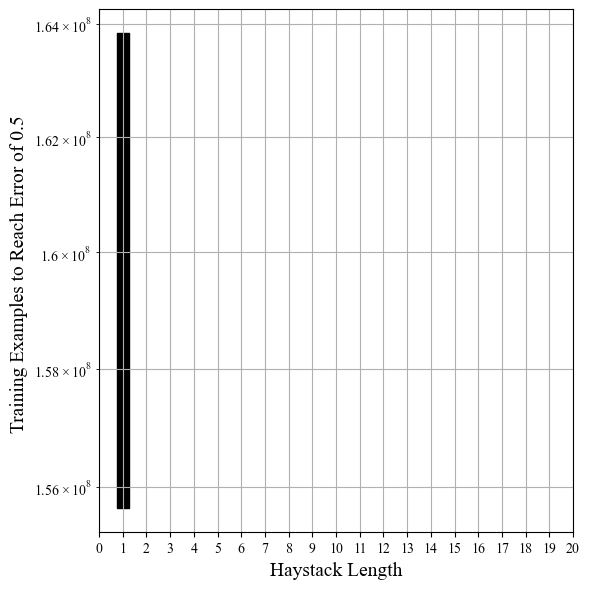

In [12]:
phase_tr_vs_haystack_len(experiment_dict)

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading x_values from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy
step: 1
qs shape: (3, 34)
step: 2
qs shape: (3, 34)
step: 3
qs shape: (3, 34)
step: 5
qs shape: (3, 34)
step: 10
qs shape: (3, 34)
haystack_len:  2
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartile

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


haystack_len:  1
Loading x_values from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy
fin_quartiles_ckpt is None for haystack_len: 1


haystack_len:  2
Loading x_values from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_2.npy
fin_quartiles_ckpt is None for haystack_len: 2


haystack_len:  3
Loading x_values from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_3.npy
fin_quartiles_ckpt is None for haystack_len: 3


haystack_len:  4
Loading x_values from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len

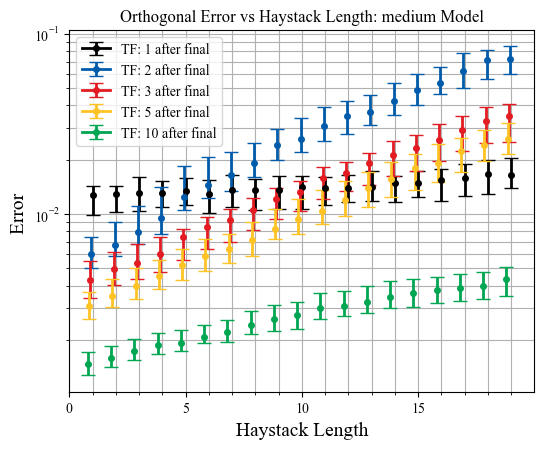

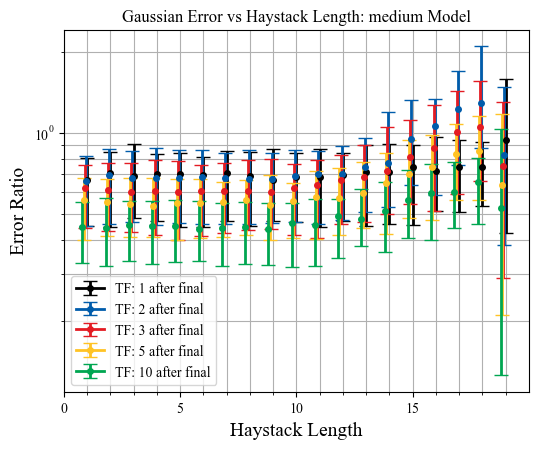

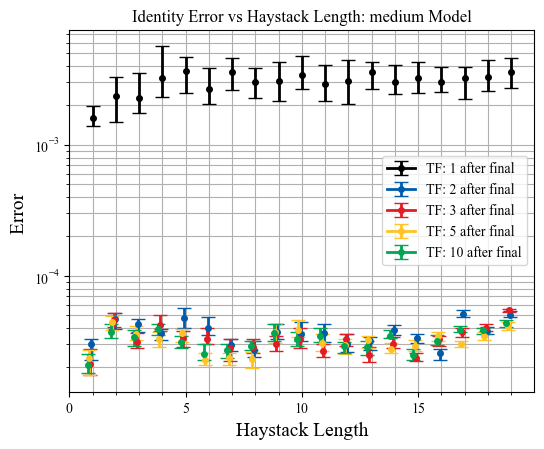

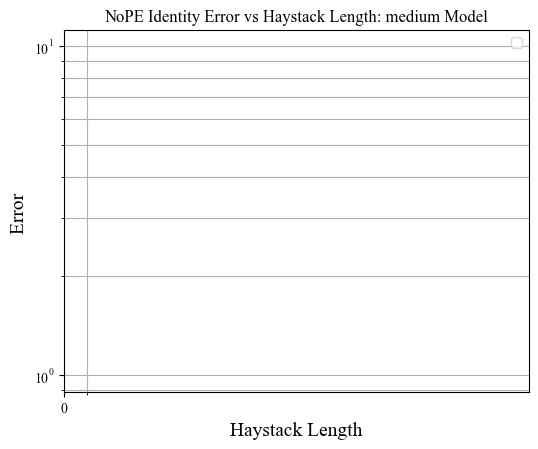

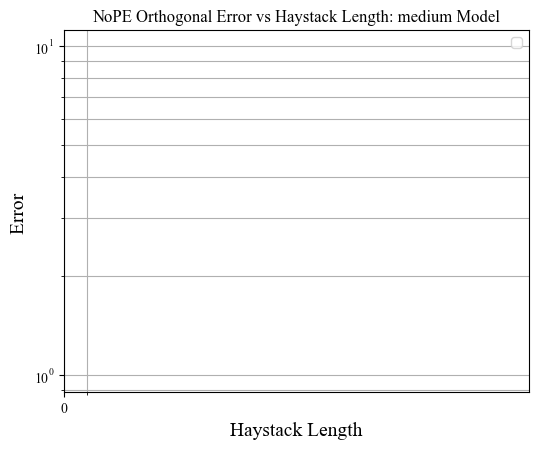

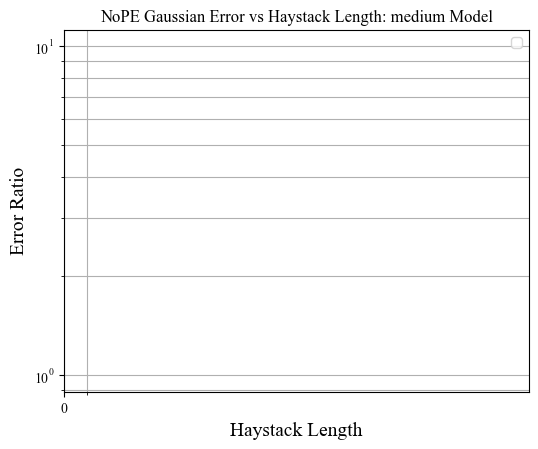

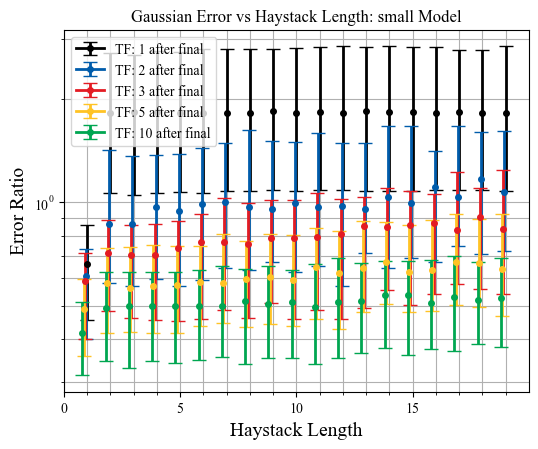

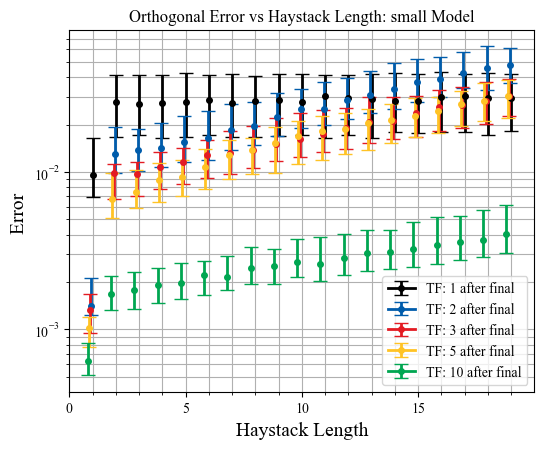

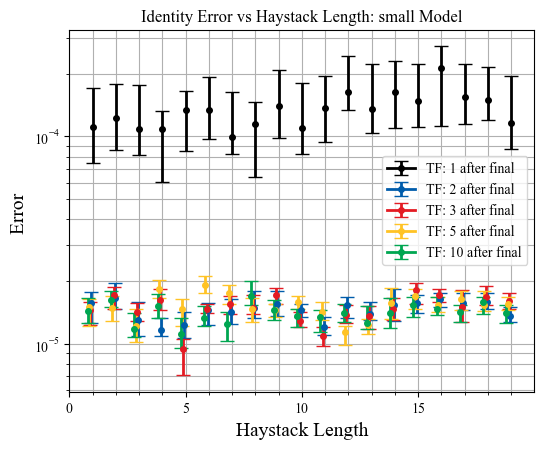

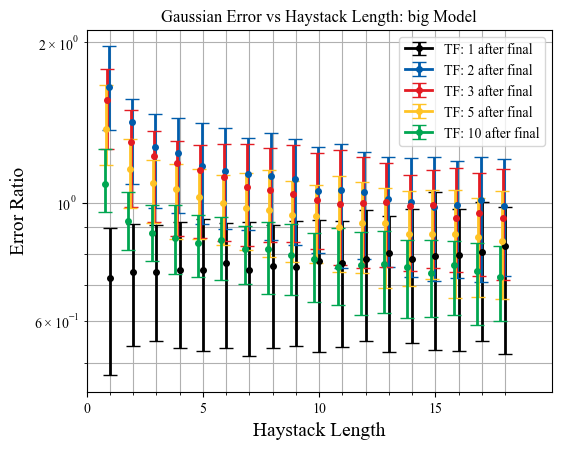

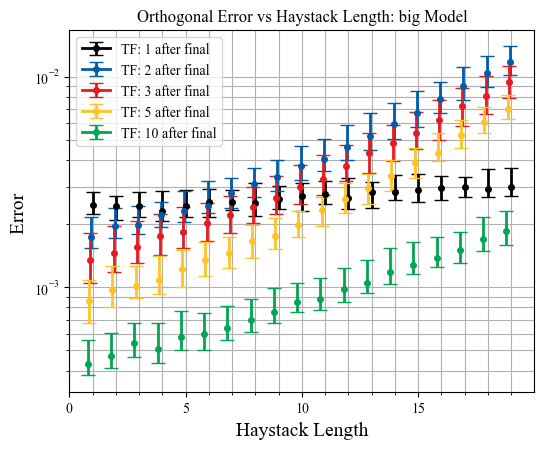

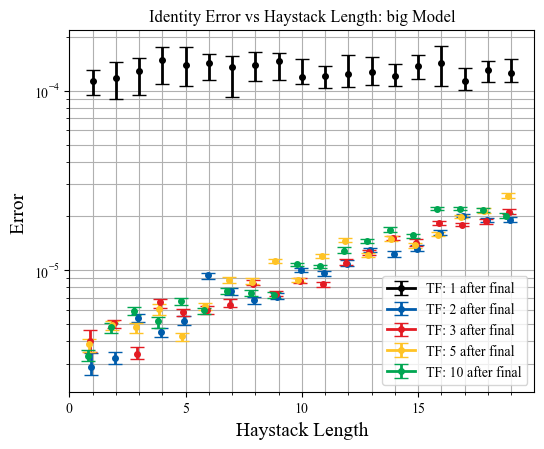

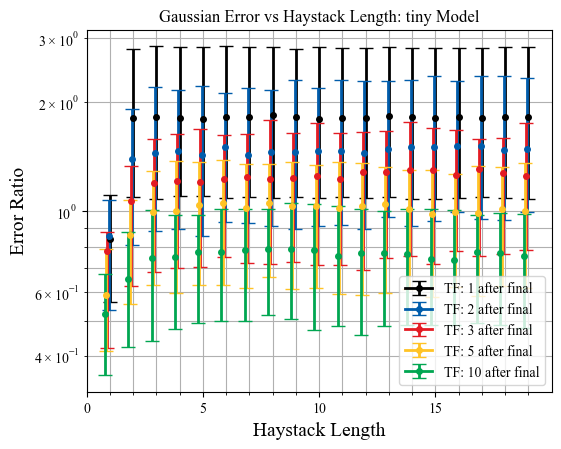

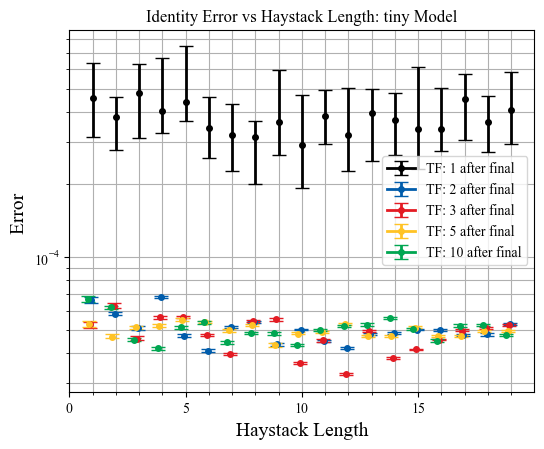

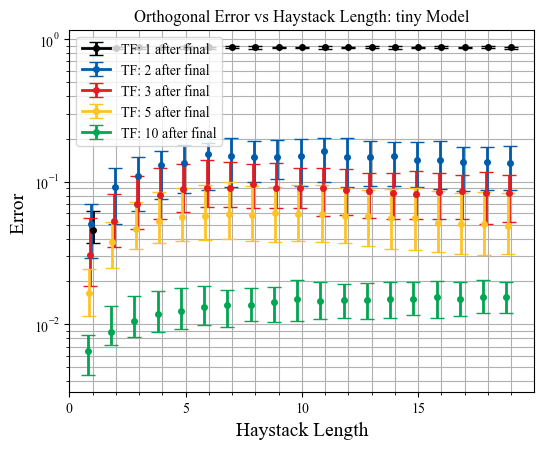

In [15]:
haystack_len_plot(experiment_dict, colors)